In [1]:
import osmnx as ox
import os
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import pandas as pd
from pyproj import CRS, Transformer

In [2]:
def get_india_states():
    current_dir = os.getcwd()
    parent_dir = os.path.dirname(current_dir)
    aoi_dir = os.path.join(parent_dir, 'aoi')

    india_path = os.path.join(aoi_dir, 'india1.json')
    india_states = gpd.read_file(india_path)
    return india_states

In [3]:
def get_lakes(longitude: float, latitude: float, distance: int, area: int = 1000000) -> gpd.GeoDataFrame:
    
    tags = {'natural': 'water'}  # Searching for natural water bodies
    
    waterbodies = ox.features_from_point((latitude, longitude), tags=tags, dist=distance)
    allowed_values = ['pond', 'reservoir', 'lake', 'basin']
    
    lakes = waterbodies[waterbodies['water'].isin(allowed_values)]
    lakes = lakes[['name', 'geometry', 'water']]

    # Ensure geometries are valid and not empty
    lakes = lakes[lakes['geometry'].notna()]
    lakes = lakes[lakes.geometry.is_valid]

    # Add centroid coordinates
    lakes["geometry_long_lat"] = lakes["geometry"]

    # Determine the appropriate UTM zone and reproject
    zone_number = int((longitude + 180) / 6) + 1
    utm_crs = CRS(f'EPSG:326{zone_number}')
    lakes = lakes.to_crs(utm_crs)
    
    transformer = Transformer.from_crs('EPSG:4326', utm_crs, always_xy=True)
    reference_point_utm = transformer.transform(longitude, latitude)
    
    lakes['area'] = lakes.geometry.area
    lakes['centroid'] = lakes.geometry.centroid

    
    lakes = lakes.sort_values(by='area', ascending=False)
    lakes['distance'] = lakes.apply(calculate_distance, axis =1, point = reference_point_utm)
    lakes['centroid_ws'] = lakes['centroid'].to_crs(epsg = 4326)

    lakes = lakes[lakes['area']>area]

    lakes = lakes[[ 'name', 'geometry_long_lat', 'area', 'distance', 'centroid_ws', 'centroid']]
    lakes = lakes.reset_index()
    return lakes

def get_all_lakes(df, distance, area = 1000000, drop_duplicated = True):
    dataframes = []
    for i, row in df.iterrows():
        longitude = row["longitude"]
        latitude = row["latitude"]
        university_lakes = get_lakes(longitude, latitude, distance, area)
        dataframes.append(university_lakes)
        university_lakes['point name'] = row["name"]

    all_lakes = pd.concat(dataframes, ignore_index=True)
    all_lakes = all_lakes.sort_values(by='area', ascending=False)
    plot_indian_lakes(df, all_lakes)
    if drop_duplicated == True:
        return drop_duplicated_lakes(all_lakes)
    return all_lakes



def calculate_distance(row, point):
    centroid_utm = row['centroid']
    return centroid_utm.distance(Point(point))

def calculate_crs(point: Point)->int:
    longitude = point.coords[0][1]
    zone_number = int((longitude + 180) / 6) + 1
    utm_crs = int(f'326{zone_number}')
    return utm_crs

def transform_geometries_by_crs(lakes: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    # Crear una lista para almacenar las geometrías transformadas
    transformed_geometries = []

    for idx, row in lakes.iterrows():
        # Obtener el CRS para el registro actual
        crs_code = row['calculated_crs']
        
        try:
            # Crear un CRS a partir del código EPSG
            crs = CRS(f'EPSG:{int(crs_code)}')

            # Crear un GeoDataFrame temporal con el CRS actual
            temp_gdf = gpd.GeoDataFrame({'geometry': [row['geometry']]}, crs='EPSG:4326')
            temp_gdf = temp_gdf.to_crs(crs)

            # Obtener la geometría transformada
            transformed_geometry = temp_gdf.iloc[0].geometry
        except Exception as e:
            print(f"Error al transformar la geometría en el índice {idx}: {e}")
            transformed_geometry = row['geometry']  # Dejar la geometría sin transformar en caso de error

        # Agregar la geometría transformada a la lista
        transformed_geometries.append(transformed_geometry)

    lakes_transformed = lakes.copy()
    lakes_transformed['geometry'] = transformed_geometries

    return lakes_transformed

def drop_duplicated_lakes(gdf):
    idx = gdf.groupby('osmid')['distance'].idxmin()
    filtered_lakes = gdf.loc[idx]

    # Resetear el índice del DataFrame resultante
    filtered_lakes = filtered_lakes.reset_index(drop=True)
    return filtered_lakes

def plot_indian_lakes(universities, lakes):
    india_states = get_india_states()
    universities['geometry'] = universities.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
    universities_gdp = gpd.GeoDataFrame(universities, geometry = 'geometry')

    fig, ax = plt.subplots(1, 1, figsize=(10, 10))

    # Plotear el mapa base de la India
    india_states.plot(ax=ax, color = 'lightgrey', edgecolor='black' )
    lakes['centroid_ws'].plot(ax=ax, color='blue', markersize=50, label='Lakes')
    
    universities_gdp.plot(ax=ax, color='red', markersize=50, label='Universities')
    plt.legend()

    # Añadir título
    plt.title('Lakes and Universities from India')

    # Mostrar el plot
    plt.show()










In [11]:
david_long = 77.3909
david_lat = 28.6208
area = 100000
lakes = get_lakes(76.8210, 30.74080, 100000)

c:\Users\agand\OneDrive\Escritorio\lakes\lake-algae-analysis\.venv\Lib\site-packages\osmnx\_overpass.py:254: UserWarning: This area is 15 times your configured Overpass max query area size. It will automatically be divided up into multiple sub-queries accordingly. This may take a long time.
  multi_poly_proj = utils_geo._consolidate_subdivide_geometry(poly_proj)


In [12]:
lakes

,element_type,osmid,name,geometry_long_lat,area,distance,centroid_ws,centroid
0,relation,1601368,Gobind Sagar,"POLYGON ((76.37541 31.57854, 76.37541 31.57766...",1.288780e+08,76217.874200,POINT (76.54295 31.38530),POINT (646712.014 3473332.523)
1,relation,8421510,Sukhna Lake,"POLYGON ((76.81058 30.74594, 76.81046 30.74591...",1.362619e+06,120.443031,POINT (76.81996 30.74141),POINT (674225.345 3402358.729)
2,way,132610001,Asan Sanctuary,"POLYGON ((77.67561 30.43539, 77.67567 30.43561...",1.240372e+06,88626.012353,POINT (77.67453 30.43491),POINT (756866.089 3370016.889)


In [89]:
latitude = 28.6208
longitude = 77.3909
sukhna_long = 76.8210
sukhna_lat = 30.74080
distance = 10000
sukhna_lakes = get_lakes(sukhna_long, sukhna_lat, distance)
sukhna_lakes.head()

,element_type,osmid,name,geometry_long_lat,area,distance,centroid_ws
0,relation,8421510,Sukhna Lake,"POLYGON ((76.81058 30.74594, 76.81046 30.74591...",1.362619e+06,120.443031,POINT (76.81996 30.74141)


Empty GeoDataFrame
Columns: [name, geometry, geometry_lat_long, approx_centroid, area, centroid, distance, centroid_ws]
Index: []


In [98]:

latitude = 28.6208
longitude = 77.3909
sukhna_long = 76.8210
sukhna_lat = 30.74080
wira_reservoir_long = 80.37812
wira_reservoir_lat = 17.21143

universities = pd.DataFrame({'name': ['Sukhna Lake', 'David work', 'Wira Reservoir'],
                            'longitude':[sukhna_long, longitude, wira_reservoir_long], 
                            'latitude': [sukhna_lat, latitude, wira_reservoir_lat]})

In [146]:
wira_lakes = get_lakes(wira_reservoir_long, wira_reservoir_lat, 200000)
wira_lakes.head()

c:\Users\agand\OneDrive\Escritorio\lakes\lake-algae-analysis\.venv\Lib\site-packages\osmnx\_overpass.py:254: UserWarning: This area is 63 times your configured Overpass max query area size. It will automatically be divided up into multiple sub-queries accordingly. This may take a long time.
  multi_poly_proj = utils_geo._consolidate_subdivide_geometry(poly_proj)


,element_type,osmid,name,geometry_long_lat,area,distance,centroid_ws,centroid
0,relation,10646204,Balimela Reservoir,"POLYGON ((82.11569 18.17119, 82.11591 18.17117...",9.013372e+07,223232.196979,POINT (82.20048 18.22173),POINT (626933.825 2015132.669)
1,way,1034979031,Nallamala Reservoir,"POLYGON ((79.09008 15.72008, 79.08933 15.70597...",6.762307e+07,208852.938195,POINT (79.13310 15.75539),POINT (299985.806 1742762.881)
2,way,217676867,Yellampalli Reservoir,"POLYGON ((79.38611 18.82868, 79.38611 18.82845...",6.359480e+07,214769.281697,POINT (79.27881 18.84262),POINT (318653.776 2084294.019)
3,relation,1579487,Manair Reservoir,"POLYGON ((79.08201 18.43193, 79.08214 18.43137...",5.244859e+07,186915.212429,POINT (79.11007 18.38511),POINT (300336.945 2033832.795)
4,relation,10215377,K L Rao Sagar,"POLYGON ((80.03490 16.75811, 80.03540 16.75981...",5.186932e+07,67978.045532,POINT (80.01050 16.70908),POINT (394508.875 1847633.995)


In [151]:
almostWira = get_lakes(wira_reservoir_long - 0.02, wira_reservoir_lat+0.01, 50000)

In [157]:
type(almostWira[almostWira['osmid'] == 7891400]['centroid'])

geopandas.geoseries.GeoSeries

In [147]:
almostWira[almostWira['name'] == 'Srisailam Lake']['centroid']

KeyError: 'centroid'

In [149]:
almostWira.columns

Index(['element_type', 'osmid', 'name', 'geometry_long_lat', 'area',
       'distance', 'centroid_ws'],
      dtype='object')

In [71]:
filetered_sukhna = sukhna_lakes[['name', 'geometry_long_lat', 'area', 'distance', 'centroid_ws']]
filtered_wira = wira_lakes[['name', 'geometry_long_lat', 'area', 'distance', 'centroid_ws']]
two = [filetered_sukhna, filtered_wira]
concat_lakes = pd.concat(two, ignore_index=True)

In [141]:
all_lakes = get_all_lakes(universities, 100000)
all_lakes.info()

c:\Users\agand\OneDrive\Escritorio\lakes\lake-algae-analysis\.venv\Lib\site-packages\osmnx\_overpass.py:254: UserWarning: This area is 15 times your configured Overpass max query area size. It will automatically be divided up into multiple sub-queries accordingly. This may take a long time.
  multi_poly_proj = utils_geo._consolidate_subdivide_geometry(poly_proj)
c:\Users\agand\OneDrive\Escritorio\lakes\lake-algae-analysis\.venv\Lib\site-packages\osmnx\_overpass.py:254: UserWarning: This area is 15 times your configured Overpass max query area size. It will automatically be divided up into multiple sub-queries accordingly. This may take a long time.
  multi_poly_proj = utils_geo._consolidate_subdivide_geometry(poly_proj)
c:\Users\agand\OneDrive\Escritorio\lakes\lake-algae-analysis\.venv\Lib\site-packages\osmnx\_overpass.py:254: UserWarning: This area is 15 times your configured Overpass max query area size. It will automatically be divided up into multiple sub-queries accordingly. This 

TypeError: get_india_states() takes 0 positional arguments but 1 was given

In [114]:
all_lakes

,element_type,osmid,name,geometry_long_lat,area,distance,centroid_ws,point name
0,relation,1601368,Gobind Sagar,"POLYGON ((76.37541 31.57854, 76.37541 31.57766...",1.288780e+08,76217.874200,POINT (76.54295 31.38530),Sukhna Lake
1,relation,7891400,NaN,"POLYGON ((79.92511 17.04583, 79.92507 17.04587...",1.185222e+06,49900.675650,POINT (79.92309 17.05269),almostWira
2,relation,7891932,NaN,"POLYGON ((80.85912 17.22955, 80.85933 17.22959...",2.945063e+06,52347.250355,POINT (80.87023 17.22607),Wira Reservoir
3,relation,8421510,Sukhna Lake,"POLYGON ((76.81058 30.74594, 76.81046 30.74591...",1.362619e+06,120.443031,POINT (76.81996 30.74141),Sukhna Lake
4,relation,10215377,K L Rao Sagar,"POLYGON ((80.03490 16.75811, 80.03540 16.75981...",5.186932e+07,67697.801901,POINT (80.01050 16.70908),almostWira
5,relation,10220456,Nagarjuna Sagar tail pond,"POLYGON ((79.37762 16.58022, 79.37575 16.58009...",1.250154e+07,122073.902260,POINT (79.41404 16.59590),almostWira
6,way,51774939,Vaddepally Lake,"POLYGON ((79.52410 17.98756, 79.52173 17.98805...",1.312223e+06,123379.546933,POINT (79.52036 17.99467),almostWira
7,way,112553260,Pakhal Lake,"POLYGON ((80.01302 17.94046, 80.01240 17.94066...",9.914095e+06,89634.671424,POINT (79.99872 17.95457),almostWira
8,way,112553299,Ranga Cheruvu,"POLYGON ((79.94648 18.04975, 79.94665 18.04991...",1.359572e+06,101318.865081,POINT (79.94594 18.04748),almostWira
9,way,114441870,NaN,"POLYGON ((80.86058 18.15075, 80.86092 18.15009...",3.851593e+06,112802.926674,POINT (80.86560 18.11762),Wira Reservoir


In [ ]:
all_lakes = drop_duplicated_lakes(all_lakes)

AttributeError: 'NoneType' object has no attribute 'groupby'

In [ ]:
all_lakes

C:\Users\agand\AppData\Local\Temp\ipykernel_26176\3621338614.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


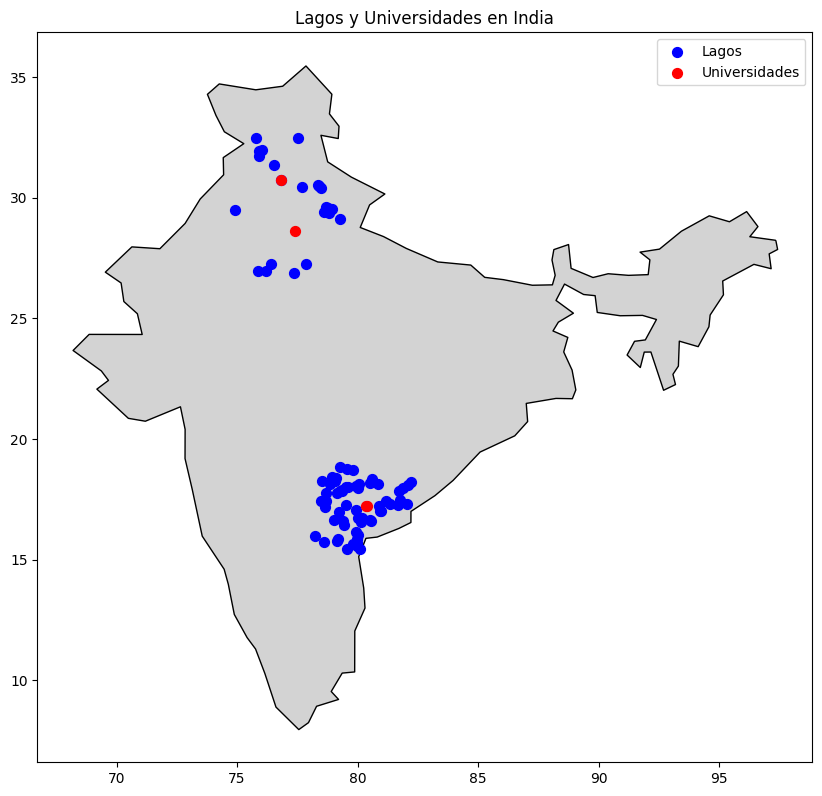

In [111]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
india = world[(world.name == 'India')]

universities['geometry'] = universities.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
universities_gdp = gpd.GeoDataFrame(universities, geometry = 'geometry')

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Plotear el mapa base de la India
india.plot(ax=ax, color='lightgrey', edgecolor='black')
all_lakes['centroid_ws'].plot(ax=ax, color='blue', markersize=50, label='Lakes')

universities_gdp.plot(ax=ax, color='red', markersize=50, label='Universities')
plt.legend()

# Añadir título
plt.title('Lakes and Universities from India')

# Mostrar el plot
plt.show()



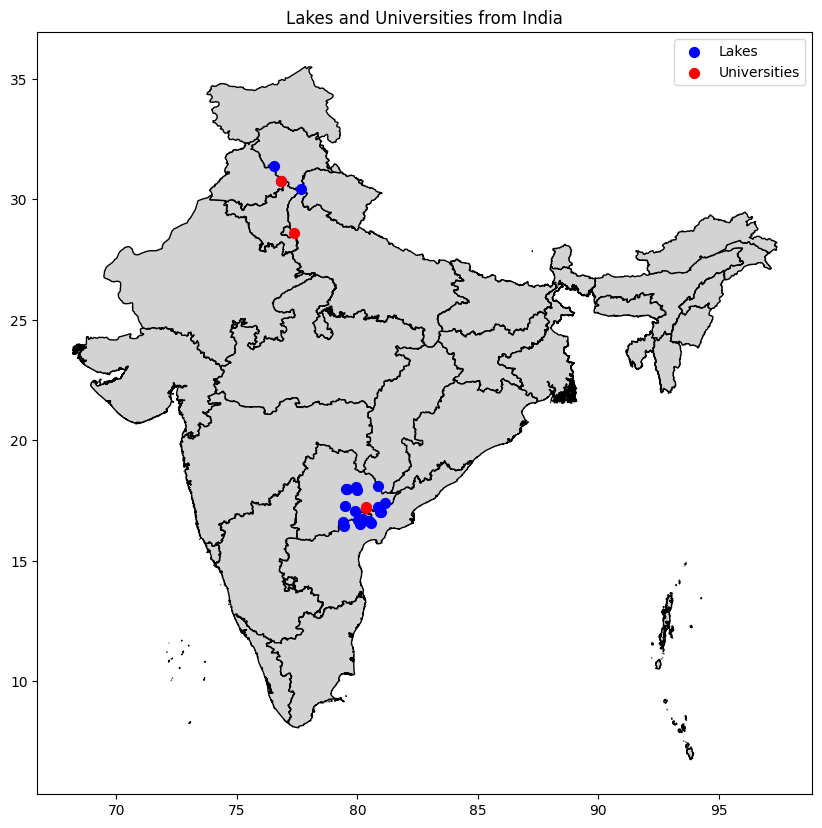

In [139]:
plot_indian_lakes(universities, all_lakes)